In [1]:
# import data
import sys
from pathlib import Path
import subprocess
import os
import gc
from glob import glob

import numpy as np
import pandas as pd
import polars as pl
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

ROOT = '/Users/bingzhi/git/finrisk/cririsk'

In [2]:
from sklearn.model_selection import TimeSeriesSplit, GroupKFold, StratifiedGroupKFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer

In [3]:
class Pipeline:

    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))
        return df

    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))  #!!?
                df = df.with_columns(pl.col(col).dt.total_days()) # t - t-1
        df = df.drop("date_decision", "MONTH")
        return df

    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()
                if isnull > 0.7:
                    df = df.drop(col)
        
        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()
                if (freq == 1) | (freq > 200):
                    df = df.drop(col)
        
        return df

In [4]:
class Aggregator:
    #Please add or subtract features yourself, be aware that too many features will take up too much space.
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        return expr_max +expr_last+expr_mean
    
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        return  expr_max +expr_last+expr_mean
    
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        #expr_count = [pl.count(col).alias(f"count_{col}") for col in cols]
        return  expr_max +expr_last#+expr_count
    
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        return  expr_max +expr_last
    
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols] 
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        return  expr_max +expr_last
    
    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

In [5]:
def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    if depth in [1,2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df)) 
    return df

def read_files(regex_path, depth=None):
    chunks = []
    
    for path in glob(str(regex_path)):
        df = pl.read_parquet(path)
        df = df.pipe(Pipeline.set_table_dtypes)
        if depth in [1, 2]:
            df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
        chunks.append(df)
    
    df = pl.concat(chunks, how="vertical_relaxed")
    df = df.unique(subset=["case_id"])
    return df

In [6]:
def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
    df_base = df_base.pipe(Pipeline.handle_dates)
    return df_base

In [7]:
def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    return df_data, cat_cols

In [8]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            continue
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [9]:
ROOT            = Path('/Users/bingzhi/git/finrisk/cririsk')

TRAIN_DIR       = ROOT / "dataset" / "train"
TEST_DIR        = ROOT / "dataset" / "test"

In [10]:
data_store = {
    "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
        read_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
        read_file(TRAIN_DIR / "train_applprev_2.parquet", 2),
        read_file(TRAIN_DIR / "train_person_2.parquet", 2)
    ]
}

In [11]:
df_train = feature_eng(**data_store)
print("train data shape:\t", df_train.shape)
del data_store
df_train = df_train.pipe(Pipeline.filter_cols)
gc.collect()

train data shape:	 (1526659, 861)


0

In [12]:
cnt_encoding_cols = df_train.select(pl.selectors.by_dtype([pl.String, pl.Boolean, pl.Categorical])).columns

mappings = {}
for col in cnt_encoding_cols:
    mappings[col] = df_train.group_by(col).len()

df_train_lazy = df_train.select(mappings.keys()).lazy()
# df_train_lazy = pl.LazyFrame(df_train.select('case_id'))

for col, mapping in mappings.items():
    remapping = {category: count for category, count in mapping.rows()}
    remapping[None] = -2
    expr = pl.col(col).replace(
                remapping,
                default=-1,
            )
    df_train_lazy = df_train_lazy.with_columns(expr.alias(col + '_cnt'))
    del col, mapping, remapping
    gc.collect()

del mappings
transformed_train = df_train_lazy.collect()

df_train = pl.concat([df_train, transformed_train.select("^*cnt$")], how='horizontal')
del transformed_train, cnt_encoding_cols

gc.collect()


0

In [13]:

df_train, cat_cols = to_pandas(df_train)
df_train = reduce_mem_usage(df_train)
print("train data shape:\t", df_train.shape)
nums=df_train.select_dtypes(exclude='category').columns
from itertools import combinations, permutations
#df_train=df_train[nums]
nans_df = df_train[nums].isna()
nans_groups={}
for col in nums:
    cur_group = nans_df[col].sum()
    try:
        nans_groups[cur_group].append(col)
    except:
        nans_groups[cur_group]=[col]
del nans_df; x=gc.collect()

def reduce_group(grps):
    use = []
    for g in grps:
        mx = 0; vx = g[0]
        for gg in g:
            n = df_train[gg].nunique()
            if n>mx:
                mx = n
                vx = gg
            #print(str(gg)+'-'+str(n),', ',end='')
        use.append(vx)
        #print()
    print('Use these',use)
    return use

def group_columns_by_correlation(matrix, threshold=0.8):
    # 计算列之间的相关性
    correlation_matrix = matrix.corr()

    # 分组列
    groups = []
    remaining_cols = list(matrix.columns)
    while remaining_cols:
        col = remaining_cols.pop(0)
        group = [col]
        correlated_cols = [col]
        for c in remaining_cols:
            if correlation_matrix.loc[col, c] >= threshold:
                group.append(c)
                correlated_cols.append(c)
        groups.append(group)
        remaining_cols = [c for c in remaining_cols if c not in correlated_cols]
    
    return groups

uses=[]
for k,v in nans_groups.items():
    if len(v)>1:
            Vs = nans_groups[k]
            #cross_features=list(combinations(Vs, 2))
            #make_corr(Vs)
            grps= group_columns_by_correlation(df_train[Vs], threshold=0.8)
            use=reduce_group(grps)
            uses=uses+use
            #make_corr(use)
    else:
        uses=uses+v
    print('####### NAN count =',k)
print(uses)
print(len(uses))
uses=uses+list(df_train.select_dtypes(include='category').columns)
print(len(uses))
df_train=df_train[uses]
df_train.drop(['requesttype_4525192L_cnt','max_empl_employedtotal_800L_cnt', 'max_empl_industry_691L_cnt'], axis=1, inplace=True)

Memory usage of dataframe is 5650.57 MB
Memory usage after optimization is: 2192.72 MB
Decreased by 61.2%
train data shape:	 (1526659, 586)
Use these ['case_id', 'WEEK_NUM', 'target', 'month_decision', 'weekday_decision', 'credamount_770A', 'applicationcnt_361L', 'applications30d_658L', 'applicationscnt_1086L', 'applicationscnt_464L', 'applicationscnt_867L', 'clientscnt_1022L', 'clientscnt_100L', 'clientscnt_1071L', 'clientscnt_1130L', 'clientscnt_157L', 'clientscnt_257L', 'clientscnt_304L', 'clientscnt_360L', 'clientscnt_493L', 'clientscnt_533L', 'clientscnt_887L', 'clientscnt_946L', 'deferredmnthsnum_166L', 'disbursedcredamount_1113A', 'downpmt_116A', 'homephncnt_628L', 'isbidproduct_1095L', 'mobilephncnt_593L', 'numactivecreds_622L', 'numactivecredschannel_414L', 'numactiverelcontr_750L', 'numcontrs3months_479L', 'numnotactivated_1143L', 'numpmtchanneldd_318L', 'numrejects9m_859L', 'sellerplacecnt_915L', 'max_mainoccupationinc_384A', 'max_birth_259D', 'max_relationshiptoclient_415T_

In [14]:
# run on mac gpu

sample = pd.read_csv("/Users/bingzhi/git/finrisk/cririsk/dataset/sample_submission.csv")
device='gpu'
#n_samples=200000
DRY_RUN = True if sample.shape[0] == 10 else False   
if DRY_RUN:
    device='cpu'
    df_train = df_train.iloc[:750000]
    #n_samples=10000
print(device)

cpu


In [15]:
data_store = {
    "df_base": read_file(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        read_file(TEST_DIR / "test_static_cb_0.parquet"),
        read_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        read_files(TEST_DIR / "test_credit_bureau_a_1_*.parquet", 1),
        read_file(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        read_file(TEST_DIR / "test_other_1.parquet", 1),
        read_file(TEST_DIR / "test_person_1.parquet", 1),
        read_file(TEST_DIR / "test_deposit_1.parquet", 1),
        read_file(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
        read_files(TEST_DIR / "test_credit_bureau_a_2_*.parquet", 2),
        read_file(TEST_DIR / "test_applprev_2.parquet", 2),
        read_file(TEST_DIR / "test_person_2.parquet", 2)
    ]
}

In [16]:
df_test = feature_eng(**data_store)
print("test data shape:\t", df_test.shape)
del data_store
gc.collect()

test data shape:	 (10, 860)


0

In [17]:
cnt_encoding_cols = df_test.select(pl.selectors.by_dtype([pl.String, pl.Boolean, pl.Categorical])).columns

mappings = {}
for col in cnt_encoding_cols:
    mappings[col] = df_test.group_by(col).len()

df_test_lazy = df_test.select(mappings.keys()).lazy()
# df_test_lazy = pl.LazyFrame(df_test.select('case_id'))

for col, mapping in mappings.items():
    remapping = {category: count for category, count in mapping.rows()}
    remapping[None] = -2
    expr = pl.col(col).replace(
                remapping,
                default=-1,
            )
    df_test_lazy = df_test_lazy.with_columns(expr.alias(col + '_cnt'))
    del col, mapping, remapping
del mappings
transformed_test = df_test_lazy.collect()

df_test = pl.concat([df_test, transformed_test.select("^*cnt$")], how='horizontal')
del transformed_test, cnt_encoding_cols

In [18]:

df_test = df_test.select([col for col in df_train.columns if col not in ['requesttype_4525192L_cnt',
                                                                         'max_empl_employedtotal_800L_cnt',
                                                                         'max_empl_industry_691L_cnt',
                                                                         "target"]])
print("train data shape:\t", df_train.shape)
print("test data shape:\t", df_test.shape)

df_test, cat_cols = to_pandas(df_test, cat_cols)
df_test = reduce_mem_usage(df_test)

gc.collect()

train data shape:	 (750000, 442)
test data shape:	 (10, 441)
Memory usage of dataframe is 0.04 MB
Memory usage after optimization is: 0.02 MB
Decreased by 45.2%


0

In [19]:
df_train.head()

,case_id,WEEK_NUM,target,month_decision,weekday_decision,credamount_770A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,...,max_cacccardblochreas_147M,last_cacccardblochreas_147M,max_conts_type_509L,last_conts_type_509L,max_conts_role_79M,max_empls_economicalst_849M,max_empls_employer_name_740M,last_conts_role_79M,last_empls_economicalst_849M,last_empls_employer_name_740M
0,0,0,0,1,4,30000.000000,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,0,1,4,19999.800781,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,0,1,5,78000.000000,0.0,0.0,0.0,0.0,...,NaN,NaN,PRIMARY_MOBILE,EMPLOYMENT_PHONE,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,0,1,4,40000.000000,0.0,1.0,0.0,2.0,...,NaN,NaN,PRIMARY_MOBILE,PRIMARY_EMAIL,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,1,1,5,44000.000000,0.0,1.0,0.0,0.0,...,NaN,NaN,PRIMARY_MOBILE,HOME_PHONE,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
convert_cols = ['month_decision', 'weekday_decision']

df_train[convert_cols] = df_train[convert_cols].astype('category')
df_test[convert_cols] = df_test[convert_cols].astype('category')

In [21]:
y = df_train["target"]
weeks = df_train["WEEK_NUM"]
df_train= df_train.drop(columns=["target", "case_id", "WEEK_NUM"])
cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

In [22]:

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 10,  
    "learning_rate": 0.05,
    "n_estimators": 2000,  
    "colsample_bytree": 0.8,
    "colsample_bynode": 0.8,
    "verbose": -1,
    "random_state": 42,
    "reg_alpha": 0.1,
    "reg_lambda": 10,
    "extra_trees":True,
    'num_leaves':64,
    "device": device, 
    "verbose": -1,
}

fitted_models = []
cv_scores = []


for idx_train, idx_valid in cv.split(df_train, y, groups=weeks):#   Because it takes a long time to divide the data set, 
    X_train, y_train = df_train.iloc[idx_train], y.iloc[idx_train]# each time the data set is divided, two models are trained to each other twice, which saves time.
    X_valid, y_valid = df_train.iloc[idx_valid], y.iloc[idx_valid]
    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set = [(X_valid, y_valid)],
        callbacks = [lgb.log_evaluation(200), lgb.early_stopping(100)] )
    fitted_models.append(model)
    y_pred_valid = model.predict_proba(X_valid)[:,1]
    auc_score = roc_auc_score(y_valid, y_pred_valid)
    cv_scores.append(auc_score)
    
print("CV AUC scores: ", cv_scores)
print("Maximum CV AUC score: ", max(cv_scores))

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.83351
[400]	valid_0's auc: 0.836694
Early stopping, best iteration is:
[490]	valid_0's auc: 0.837193
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.825133
[400]	valid_0's auc: 0.829572
[600]	valid_0's auc: 0.830737
Early stopping, best iteration is:
[604]	valid_0's auc: 0.830791
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.829202
[400]	valid_0's auc: 0.832842
[600]	valid_0's auc: 0.833551
Early stopping, best iteration is:
[564]	valid_0's auc: 0.833673
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.833708
[400]	valid_0's auc: 0.837526
[600]	valid_0's auc: 0.838701
Early stopping, best iteration is:
[553]	valid_0's auc: 0.838784
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.828759
[400]	valid_0's auc: 0.832713
[600]	valid_0's auc: 0.833596
Early stopp

In [22]:
df_train.iloc[idx_train]

NameError: name 'idx_train' is not defined

In [23]:
#lLogistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
iterative_imputer = IterativeImputer()
simple_imputer = SimpleImputer(strategy='mean')


In [28]:
# 定义逻辑回归模型的参数
logistic_params = {
    "random_state": 42,
    "max_iter": 10,
    "solver": 'liblinear'  # 对于小数据集或二分类问题，'liblinear'是个不错的选择
}

In [24]:
nums_wo_id = [col for col in df_train.select_dtypes(exclude='category').columns if col not in ['case_id']]

In [25]:
for idx_train, idx_valid in cv.split(df_train, y, groups=weeks):#   Because it takes a long time to divide the data set, 
    X_train, y_train = df_train.iloc[idx_train], y.iloc[idx_train]# each time the data set is divided, two models are trained to each other twice, which saves time.
    X_valid, y_valid = df_train.iloc[idx_valid], y.iloc[idx_valid]

In [26]:
# 准备交叉验证
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fitted_models = []
cv_scores = []
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', iterative_imputer),
            ('scaler', StandardScaler())]), nums_wo_id),  # nums是数值型特征列的列表
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)  # cat_cols是分类特征列的列表
    ])


In [29]:
preprocessor_simple = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', simple_imputer),
            ('scaler', StandardScaler())]), nums_wo_id),  # nums是数值型特征列的列表
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)  # cat_cols是分类特征列的列表
    ])

In [30]:
# 创建包含预处理和模型的管道
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_simple),
    ('classifier', LogisticRegression(**logistic_params))
])

In [47]:

preprocessed_data = preprocessor_simple.fit_transform(df_train)
# 假设您已有 preprocessed_data 作为 csr_matrix，以及完整的列名列表 all_feature_names
# 转换 csr_matrix 为完整 DataFrame
preprocessed_df = pd.DataFrame.sparse.from_spmatrix(preprocessed_data, columns=all_feature_names)

# 由于您的数据在转换后可能依然是稀疏格式，确保它是密集格式，以便于查看和导出
dense_df = preprocessed_df.sparse.to_dense()

# 打印前几行确保数据正确
print(dense_df.head())

# 导出数据到 CSV，现在每个数据点和它的列名是一一对应的
dense_df.to_csv('preprocessed_data.csv', index=False)


   credamount_770A  applicationcnt_361L  applications30d_658L  \
0        -0.422531            -0.003612             -0.269976   
1        -0.657670            -0.003612             -0.269976   
2         0.706110            -0.003612             -0.269976   
3        -0.187398            -0.003612              1.664562   
4        -0.093344            -0.003612              1.664562   

   applicationscnt_1086L  applicationscnt_464L  applicationscnt_867L  \
0               -0.12633             -0.147676             -0.490335   
1               -0.12633             -0.147676             -0.490335   
2               -0.12633             -0.147676             -0.490335   
3               -0.12633              0.010122             -0.258147   
4               -0.12633             -0.147676             -0.258147   

   clientscnt_1022L  clientscnt_100L  clientscnt_1071L  clientscnt_1130L  ...  \
0         -0.074323         -0.15312         -0.183081         -0.168673  ...   
1         -0.0

In [50]:
y_train
# export to csv
y_train.to_csv('target.csv', index=False)

: 

In [33]:
# 使用管道训练模型
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['credamount_770A',
                                                   'applicationcnt_361L',
                                                   'applications30d_658L',
                                                   'applicationscnt_1086L',
                                                   'applicationscnt_464L',
                                                   'applicationscnt_867L',
                                                   'clientscnt_1022L',
                                                   'clientscnt_100L',
                                                   'clientscnt_1071L',
                                                   'clientscnt_113...
                                                   'max_cancelreason_3545846M',
                                                   'max_education_1138M',
                                                   'max_postype_4733339M',
                                                   'max_rejectreason_755M',
                                                   'max_rejectreasonclient_4145042M',
                                                   'last_cancelreason_3545846M',
                                                   'last_education_1138M',
                                                   'last_postype_4733339M',
                                                   'last_rejectreason_755M',
                                                   'last_rejectreasonclient_4145042M', ...])])),
                ('classifier',
                 LogisticRegression(max_iter=10, random_state=42,
                                    solver='liblinear'))])

In [40]:
# logistic regression model
# CV AUC scores: [0.7954352367530565]
# Average CV AUC score: 0.7954352367530565
y_pred = pipeline.predict_proba(X_valid)[:, 1]
score = roc_auc_score(y_valid, y_pred)
cv_scores.append(score)

# 输出交叉验证的AUC分数
print("CV AUC scores:", cv_scores)
print("Average CV AUC score:", np.mean(cv_scores))

CV AUC scores: [0.7954352367530565]
Average CV AUC score: 0.7954352367530565


In [42]:
#decision tree model
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

# 决策树的参数
tree_params = {
    "criterion": "gini",
    "max_depth": 10,
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "random_state": 42
}
# 数值型数据的预处理
simple_imputer = SimpleImputer(strategy='median')  # 用中位数填补数值型特征的缺失值

# 定义处理数值型特征的管道
num_pipeline = Pipeline(steps=[
    ('imputer', simple_imputer),
    ('scaler', StandardScaler())
])

# 定义ColumnTransformer
preprocessor_simple = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, nums_wo_id),  # 应用于数值型特征
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)  # 应用于分类特征
    ])


In [46]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for idx_train, idx_valid in cv.split(df_train, y, groups=weeks):
    X_train, y_train = df_train.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = df_train.iloc[idx_valid], y.iloc[idx_valid]

# 使用preprocessor进行数据预处理
X_transformed = preprocessor_simple.fit_transform(X_train)
X_transformed_valid = preprocessor_simple.transform(X_valid)


In [47]:
# decision tree model
# CV AUC scores:  [0.7355668604842867]
# Maximum CV AUC score:  0.7355668604842867
model = DecisionTreeClassifier(**tree_params)
model.fit(X_transformed, y_train)
y_pred_valid = model.predict_proba(X_transformed_valid)[:, 1]
auc_score = roc_auc_score(y_valid, y_pred_valid)
cv_scores.append(auc_score)

print("CV AUC scores: ", cv_scores)
print("Maximum CV AUC score: ", max(cv_scores))


CV AUC scores:  [0.7355668604842867]
Maximum CV AUC score:  0.7355668604842867


In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
rf_params = {
    "n_estimators": 2000,
    "max_depth": 10,
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    #"max_features": 'auto',  # 相当于 colsample_bytree
    "bootstrap": True,  # 使用放回抽样
    "random_state": 42,
    "n_jobs": -1  # 使用所有可用的CPU核心
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
fitted_models = []
model = RandomForestClassifier(**rf_params)
model.fit(X_transformed, y_train)
y_pred_valid = model.predict_proba(X_transformed_valid)[:, 1]
auc_score = roc_auc_score(y_valid, y_pred_valid)

fitted_models.append(model)
cv_scores.append(auc_score)

rm accuracy
CV AUC scores: [0.7870526458230729]
Average CV AUC score: 0.7870526458230729

In [50]:
print("CV AUC scores:", cv_scores)
print("Average CV AUC score:", np.mean(cv_scores))

CV AUC scores: [0.7870526458230729]
Average CV AUC score: 0.7870526458230729


In [23]:
class VotingModel(BaseEstimator, RegressorMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)
    
    def predict_proba(self, X):
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

model = VotingModel(fitted_models)

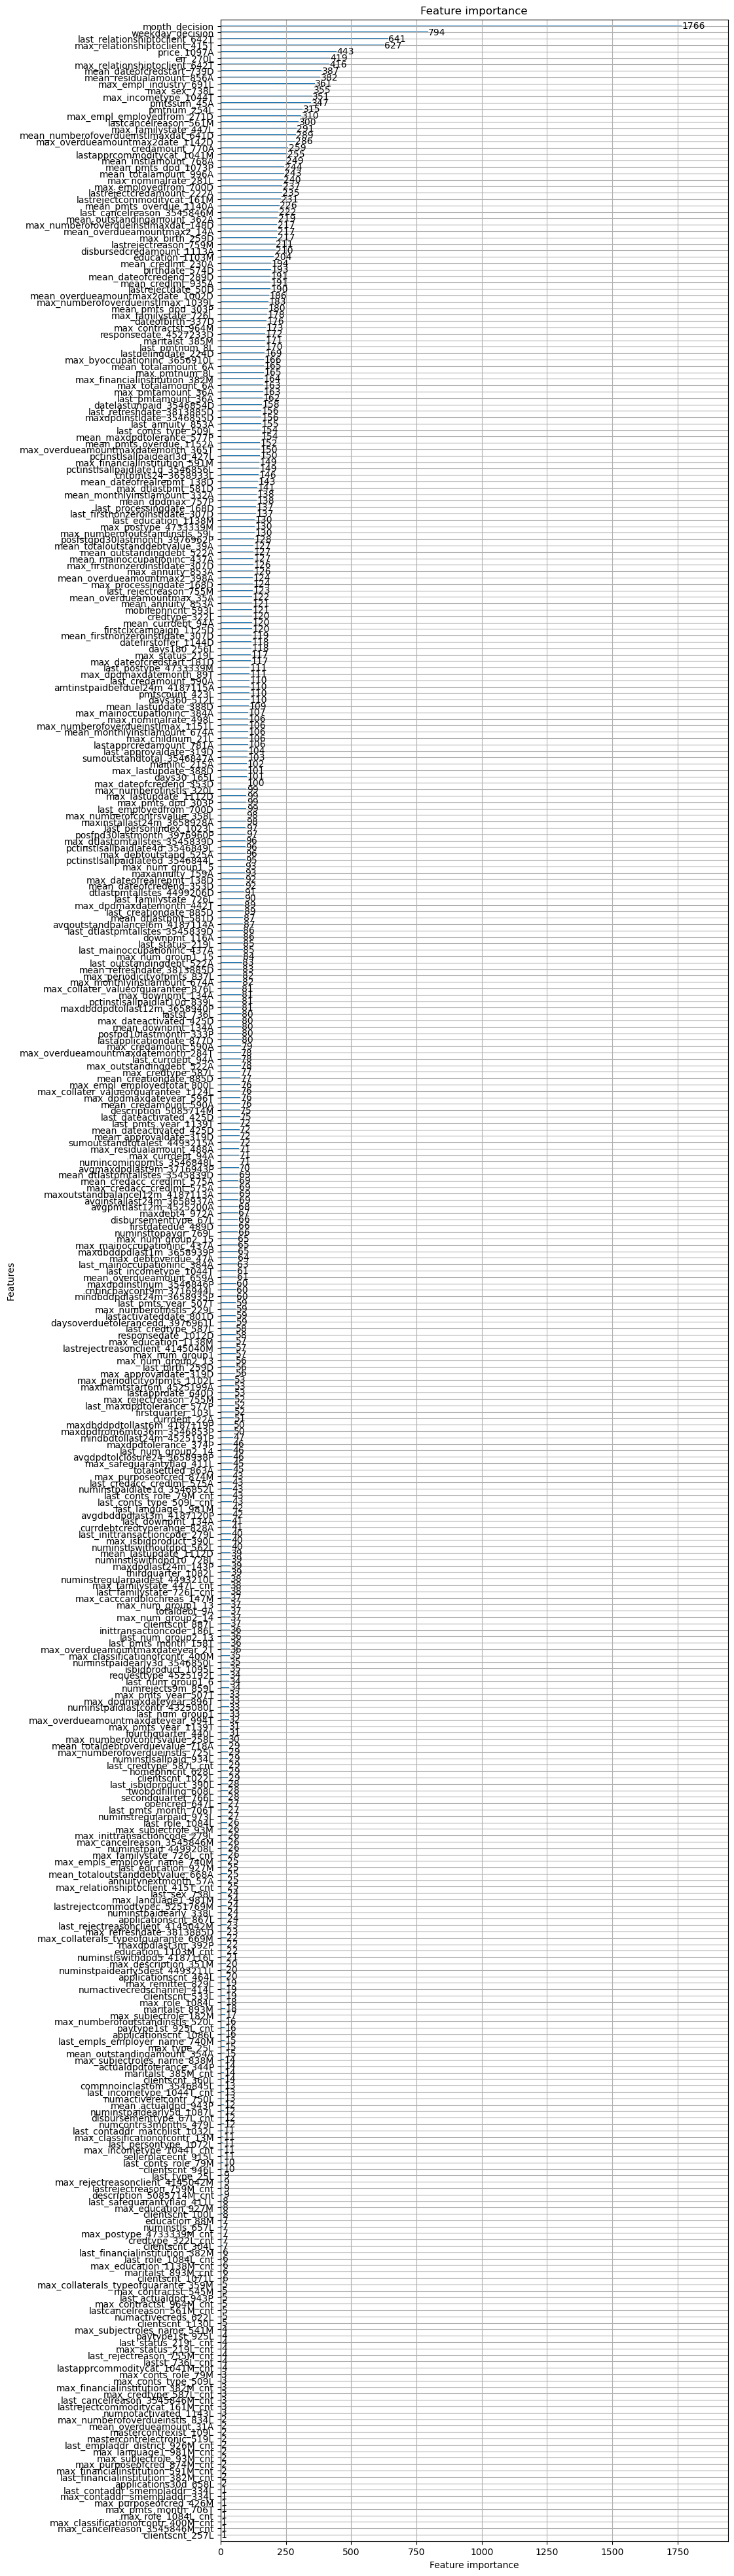

In [24]:
lgb.plot_importance(fitted_models[2], importance_type="split", figsize=(10,50))
plt.show()

In [25]:
features = X_train.columns
importances = fitted_models[2].feature_importances_
feature_importance = pd.DataFrame({'importance':importances,'features':features}).sort_values('importance', ascending=False).reset_index(drop=True)
feature_importance

drop_list = []
for i, f in feature_importance.iterrows():
    if f['importance']<80:
        drop_list.append(f['features'])
print(f"Number of features which are not important: {len(drop_list)} ")

print(drop_list)

Number of features which are not important: 280 
['max_credamount_590A', 'max_overdueamountmaxdatemonth_284T', 'last_currdebt_94A', 'max_outstandingdebt_522A', 'max_credtype_587L', 'mean_creationdate_885D', 'max_dpdmaxdateyear_596T', 'mean_credamount_590A', 'max_collater_valueofguarantee_1124L', 'max_empl_employedtotal_800L', 'description_5085714M', 'last_dateactivated_425D', 'mean_approvaldate_319D', 'sumoutstandtotalest_4493215A', 'mean_dateactivated_425D', 'last_pmts_year_1139T', 'max_residualamount_488A', 'max_currdebt_94A', 'numincomingpmts_3546848L', 'avgmaxdpdlast9m_3716943P', 'max_credacc_credlmt_575A', 'maxoutstandbalancel12m_4187113A', 'avginstallast24m_3658937A', 'mean_credacc_credlmt_575A', 'mean_dtlastpmtallstes_3545839D', 'avgpmtlast12m_4525200A', 'maxdebt4_972A', 'disbursementtype_67L', 'firstdatedue_489D', 'numinsttopaygr_769L', 'maxdbddpdlast1m_3658939P', 'max_mainoccupationinc_437A', 'max_num_group2_15', 'max_debtoverdue_47A', 'last_mainoccupationinc_384A', 'mean_over